<a target="_blank" href="https://colab.research.google.com/github/LuoYanHao-2025/Data_Science_Group31/blob/cf37e58ed7811420f27bbcbe17ffe85a56aab8c7/Project_on_diabetes.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1 Preprocessing
## 1.1 Data Cleaning

### 1.1.1 Concatenation/Integrating
Usually we clean different dataset repectively and then concatenate them. However, the CDC questionnaire are from the surveyees with the same SEQN, which means the separate datasets are in fact one unitary dataset at first. We concatenate first thus we drop some surveyees lack of columns we care about, alleviating the work amount of data cleaning.

### 1.1.2 Drop the irrelavent **columns**

Too many columns included in the origin dataset. Only select those we use to import.

In [2]:
import pandas as pd
import numpy as np

# Define file paths
base_path = "/content/drive/MyDrive/WIA1007_Project/"

# Dictionary mapping CDC variable codes to readable English names
# Key: CDC Code, Value: Readable Name
columns_map = {
    # --- Identifiers ---
    'SEQN': 'ID',

    # --- Target Variables (To construct the Diabetes Label) ---
    'DIQ010': 'doctor_diabetes_diagnosis',  # 1=Yes, 2=No, 3=Borderline
    'LBXGLU': 'fasting_glucose_mg_dl',      # Lab: Fasting Glucose
    'LBXGH':  'glycohemoglobin_percent',    # Lab: HbA1c (Long-term sugar)

    # --- Demographics (Easy to get) ---
    'RIDAGEYR': 'age',
    'RIAGENDR': 'gender',                   # 1=Male, 2=Female
    'INDFMPIR': 'poverty_income_ratio',     # Socioeconomic status (Family income / Poverty guideline)

    # --- Body Measures (Non-invasive) ---
    'BMXBMI':   'bmi',
    'BMXWAIST': 'waist_circumference_cm',   # Waist is a strong predictor for metabolic issues

    # --- Lifestyle: Sleep ---
    'SLD012': 'sleep_hours',

    # --- Lifestyle: Mental Health ---
    'DPQ020': 'depression_feeling_frequency', # 0=Not at all -> 3=Nearly every day

    # --- Lifestyle: Substance Use ---
    'SMQ040': 'smoking_status',             # Do you now smoke? (1=Every day, 2=Some days, 3=Not at all)
    'ALQ130': 'alcohol_drinks_per_day',     # Average alcoholic drinks per day (Past 12 mos)

    # --- Lifestyle: Physical Activity (Raw columns for calculation) ---
    'PAD680':  'sedentary_minutes_per_day',
    'PAD790Q': 'moderate_activity_freq',    # Frequency (Number)
    'PAD790U': 'moderate_activity_unit',    # Unit (Day/Week/Month)
    'PAD800':  'moderate_activity_duration',# Duration (Minutes)
    'PAD810Q': 'vigorous_activity_freq',
    'PAD810U': 'vigorous_activity_unit',
    'PAD820':  'vigorous_activity_duration'
}

# List of files to read and their specific columns to keep
# We only load columns that are in our map to save memory and avoid clutter
files_config = [
    {'path': base_path + "DIQ_L.xpt", 'cols': ['SEQN', 'DIQ010']},
    {'path': base_path + "GLU_L.xpt", 'cols': ['SEQN', 'LBXGLU']},
    {'path': base_path + "GHB_L.xpt", 'cols': ['SEQN', 'LBXGH']},
    {'path': base_path + "DEMO_L.xpt",'cols': ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'INDFMPIR']},
    {'path': base_path + "BMX_L.xpt", 'cols': ['SEQN', 'BMXBMI', 'BMXWAIST']},
    {'path': base_path + "SLQ_L.xpt", 'cols': ['SEQN', 'SLD012']},
    {'path': base_path + "DPQ_L.xpt", 'cols': ['SEQN', 'DPQ020']},
    {'path': base_path + "SMQ_L.xpt", 'cols': ['SEQN', 'SMQ040']},
    {'path': base_path + "ALQ_L.xpt", 'cols': ['SEQN', 'ALQ130']},
    {'path': base_path + "PAQ_L.xpt", 'cols': ['SEQN', 'PAD680', 'PAD790Q', 'PAD790U', 'PAD800', 'PAD810Q', 'PAD810U', 'PAD820']}
]

# 1. Read and Merge Dataframes
print("Loading and merging datasets...")
df_final = None

for config in files_config:
    # Read SAS file
    df_temp = pd.read_sas(config['path'])

    # Filter columns: keep only those in our list if they exist in the file
    # (Using intersection to avoid errors if a column name varies slightly)
    cols_to_keep = [c for c in config['cols'] if c in df_temp.columns]
    df_temp = df_temp[cols_to_keep]

    # Merge logic
    if df_final is None:
        df_final = df_temp
    else:
        # Outer merge to keep everyone, we will handle missing values later
        # Using 'inner' is also fine if you want strict complete cases
        df_final = pd.merge(df_final, df_temp, on='SEQN', how='outer')

# 2. Rename Columns
print("Renaming columns to readable English names...")
df_final = df_final.rename(columns=columns_map)

Loading and merging datasets...
Renaming columns to readable English names...


In [3]:
print(df_final.isna().sum())

ID                                 0
doctor_diabetes_diagnosis        193
fasting_glucose_mg_dl           8261
glycohemoglobin_percent         5218
age                                0
gender                             0
poverty_income_ratio            2041
bmi                             3462
waist_circumference_cm          3743
sleep_hours                     3545
depression_feeling_frequency    6415
smoking_status                  8690
alcohol_drinks_per_day          7864
sedentary_minutes_per_day       3795
moderate_activity_freq          3798
moderate_activity_unit          3780
moderate_activity_duration      5543
vigorous_activity_freq          3794
vigorous_activity_unit          3780
vigorous_activity_duration      8246
dtype: int64


The condition of data is quite well. But there are still something we need to fix:
1. The columns' titles are in CDC code, needed to be converted to human-readable text.
2. A few missing values.
3. CDC usually uses some error code, like 9999 and 7777. Drop them and replace them with 0 or Na (it denpends).

### 1.1.3 Translation

CDC utilizes some special code to represent `don't know` and `refuse`. Drop these cells and replace them with `np.na` or other default values.

In [4]:
error_codes_map = {
    # 7/9
    'doctor_diabetes_diagnosis': [7, 9],
    'depression_feeling_frequency': [7, 9],
    'smoking_status': [7, 9],

    # 777/999
    'alcohol_drinks_per_day': [777, 999],

    # 7777/9999
    'sedentary_minutes_per_day': [7777, 9999],
    'moderate_activity_freq': [7777, 9999],
    'moderate_activity_duration': [7777, 9999],
    'vigorous_activity_freq': [7777, 9999],
    'vigorous_activity_duration': [7777, 9999]
}

for col, codes in error_codes_map.items():
    if col in df_final.columns:
        df_final[col] = df_final[col].replace(codes, np.nan)

# change the borderline to no-diabete
df_final['doctor_diabetes_diagnosis'] = df_final['doctor_diabetes_diagnosis'].replace(3, 2)

In [5]:
df_final.head()

,ID,doctor_diabetes_diagnosis,fasting_glucose_mg_dl,glycohemoglobin_percent,age,gender,poverty_income_ratio,bmi,waist_circumference_cm,sleep_hours,depression_feeling_frequency,smoking_status,alcohol_drinks_per_day,sedentary_minutes_per_day,moderate_activity_freq,moderate_activity_unit,moderate_activity_duration,vigorous_activity_freq,vigorous_activity_unit,vigorous_activity_duration
0,130378.0,2.0,113.0,5.6,43.0,1.0,5.00,27.0,98.3,9.5,NaN,3.0,NaN,360.0,3.0,b'W',45.0,3.000000e+00,b'W',45.0
1,130379.0,2.0,99.0,5.6,66.0,1.0,5.00,33.5,114.7,9.0,5.397605e-79,3.0,3.0,480.0,4.0,b'W',45.0,3.000000e+00,b'W',45.0
2,130380.0,1.0,156.0,6.2,44.0,2.0,1.41,29.7,93.5,8.0,5.397605e-79,NaN,1.0,240.0,1.0,b'W',20.0,5.397605e-79,b'',NaN
3,130381.0,2.0,NaN,NaN,5.0,2.0,1.53,23.8,70.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,2.0,NaN,NaN,2.0,1.0,3.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1.4 Reduction
For activity levels, there are an extra column for unit. Convert them into one unit.

In [6]:
# There are various Units for frequency in PA
for dictName in {"moderate_activity_unit","vigorous_activity_unit"}:
  print("\nUnique Category for "+dictName)
  print(df_final[dictName].unique())


Unique Category for vigorous_activity_unit
[b'W' b'' nan b'M' b'D' b'Y']

Unique Category for moderate_activity_unit
[b'W' nan b'' b'D' b'M' b'Y']


In [7]:
# converting all the frequency into PER WEEK
def convert_to_weekly_frequency(df_merged):
    # converting function/formula
    def convert_frequency(freq, unit):
        # Invalid value handling
        if pd.isna(freq) or freq in [7777, 9999]:
            return np.nan

        unit_str = unit.decode('utf-8') if isinstance(unit, bytes) else str(unit)
        # if no unit, speculate it by the rule provided by CDC
        if pd.isna(unit_str) or unit_str == '':
            if freq <= 4:
                unit_str = 'D'
            elif freq <= 28:
                unit_str = 'W'
            elif freq <= 31:
                unit_str = 'M'
            elif freq <= 365:
                unit_str = 'Y'
            else:
                return np.nan

        # calculate valid rows
        if unit_str == 'D':
            return freq * 7
        elif unit_str == 'W':
            return freq
        elif unit_str == 'M':
            return freq * 4.345
        elif unit_str == 'Y':
            return freq / 52
        else:
            return np.nan

    # handle the moderate
    df_merged['moderate_activity_w'] = df_merged.apply(
        lambda row: convert_frequency(row['moderate_activity_freq'],row['moderate_activity_unit']),axis=1
    )

    # handle the vigorous
    df_merged['vigorous_activity_w'] = df_merged.apply(
        lambda row: convert_frequency(row['vigorous_activity_freq'],row['vigorous_activity_unit']),axis=1
    )

    # drop the old columns
    columns_to_drop = ['moderate_activity_freq', 'moderate_activity_unit','vigorous_activity_freq', 'vigorous_activity_unit']

    existing_columns = [col for col in columns_to_drop if col in df_merged.columns]
    df_merged = df_merged.drop(columns=existing_columns)

    return df_merged

df_final = convert_to_weekly_frequency(df_final)

In [8]:
# Check the result
df_final.head()

,ID,doctor_diabetes_diagnosis,fasting_glucose_mg_dl,glycohemoglobin_percent,age,gender,poverty_income_ratio,bmi,waist_circumference_cm,sleep_hours,depression_feeling_frequency,smoking_status,alcohol_drinks_per_day,sedentary_minutes_per_day,moderate_activity_duration,vigorous_activity_duration,moderate_activity_w,vigorous_activity_w
0,130378.0,2.0,113.0,5.6,43.0,1.0,5.00,27.0,98.3,9.5,NaN,3.0,NaN,360.0,45.0,45.0,3.0,3.000000e+00
1,130379.0,2.0,99.0,5.6,66.0,1.0,5.00,33.5,114.7,9.0,5.397605e-79,3.0,3.0,480.0,45.0,45.0,4.0,3.000000e+00
2,130380.0,1.0,156.0,6.2,44.0,2.0,1.41,29.7,93.5,8.0,5.397605e-79,NaN,1.0,240.0,20.0,NaN,1.0,3.778324e-78
3,130381.0,2.0,NaN,NaN,5.0,2.0,1.53,23.8,70.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,2.0,NaN,NaN,2.0,1.0,3.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The same situation on data reduction is on diagnosis of diabetes:  
Defining the Target Variable:Following the guidelines from the American Diabetes Association (ADA) and the Centers for Disease Control and Prevention (CDC), we defined a participant as having diabetes (Target=1) if they met any of the following criteria:
1. HbA1c level $\ge 6.5\%$\
2. Fasting Plasma Glucose $\ge 126$ mg/dL.
3. Self-reported diagnosis by a doctor/health professional ("Yes" to questionnaire DIQ010).  
Participants who met none of these criteria were classified as Non-Diabetic (Target=0).

In [9]:
def define_diabetes_label(row):
    doctor_said = row['doctor_diabetes_diagnosis']   # 1=Yes, 2=No
    hba1c = row['glycohemoglobin_percent']       # Threshold: 6.5
    glucose = row['fasting_glucose_mg_dl']       # Threshold: 126

    if doctor_said == 1:
        return 1

    if pd.notna(hba1c) and hba1c >= 6.5:
        return 1

    if pd.notna(glucose) and glucose >= 126:
        return 1

    if pd.isna(doctor_said) and pd.isna(hba1c) and pd.isna(glucose):
        return np.nan

    return 0

df_final['diabetes_target'] = df_final.apply(define_diabetes_label, axis=1)

# Drop those cannot be diagnosed. They may disturb our result.
original_len = len(df_final)
print(f"{original_len} samples in total")
df_final = df_final.dropna(subset=['diabetes_target'])
print(f" {original_len - len(df_final)} samples are dropped.")

11933 samples in total
 196 samples are dropped.


In [10]:
columns_to_drop = ['doctor_diabetes_diagnosis', 'fasting_glucose_mg_dl','glycohemoglobin_percent']

existing_columns = [col for col in columns_to_drop if col in df_final.columns]
df_final = df_final.drop(columns=existing_columns)

There are some extremely small numbers which are supposed to be errors. Replace them with 0 (notice that cells with extremely small numbers are usually with some NaN in the same line, making it be 0 reasonable, supporting our operation).

In [11]:
df_final = df_final.map(lambda x: 0 if isinstance(x, (int, float)) and abs(x) < 1e-5 else x)

In [12]:
df_final.head()

,ID,age,gender,poverty_income_ratio,bmi,waist_circumference_cm,sleep_hours,depression_feeling_frequency,smoking_status,alcohol_drinks_per_day,sedentary_minutes_per_day,moderate_activity_duration,vigorous_activity_duration,moderate_activity_w,vigorous_activity_w,diabetes_target
0,130378.0,43.0,1.0,5.00,27.0,98.3,9.5,NaN,3.0,NaN,360.0,45.0,45.0,3.0,3.0,0.0
1,130379.0,66.0,1.0,5.00,33.5,114.7,9.0,0.0,3.0,3.0,480.0,45.0,45.0,4.0,3.0,0.0
2,130380.0,44.0,2.0,1.41,29.7,93.5,8.0,0.0,NaN,1.0,240.0,20.0,NaN,1.0,0.0,1.0
3,130381.0,5.0,2.0,1.53,23.8,70.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,130382.0,2.0,1.0,3.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### 1.1.4 Filling the missing Values
NA with a related column value 0 is a 0 which is given by subject who feel confused with refill the same thing or generated by computer system automatically.

In [13]:
activity_pairs = [
    ('moderate_activity_duration', 'moderate_activity_w'),
    ('vigorous_activity_duration', 'vigorous_activity_w')
]

for minutes, weekly in activity_pairs:
    # time = 0, then frequency should be 0
    df_final.loc[df_final[minutes] == 0, weekly] = 0
    # freq = 0, then time should be 0
    df_final.loc[df_final[weekly] == 0, minutes] = 0
    # when one of it is 0, the other is NA, the NA one is 0(the surveyee was confused so leaving it empty)
    df_final.loc[(df_final[minutes].isna()) & (df_final[weekly] == 0), minutes] = 0
    df_final.loc[(df_final[weekly].isna()) & (df_final[minutes] == 0), weekly] = 0

In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11737 entries, 0 to 11932
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            11737 non-null  float64
 1   age                           11737 non-null  float64
 2   gender                        11737 non-null  float64
 3   poverty_income_ratio          9728 non-null   float64
 4   bmi                           8470 non-null   float64
 5   waist_circumference_cm        8189 non-null   float64
 6   sleep_hours                   8387 non-null   float64
 7   depression_feeling_frequency  5508 non-null   float64
 8   smoking_status                3242 non-null   float64
 9   alcohol_drinks_per_day        4055 non-null   float64
 10  sedentary_minutes_per_day     8064 non-null   float64
 11  moderate_activity_duration    8066 non-null   float64
 12  vigorous_activity_duration    8085 non-null   float64
 13  modera

We have to drop columns Smoke and Alcohol because there are too much missing data to be reliable.

In [15]:
cols_to_drop = ['smoking_status', 'alcohol_drinks_per_day']
df_final = df_final.drop(columns=cols_to_drop)

In [16]:
# sleep: yes! sedentary also is considered as sleep logically
median_colums = ["sleep_hours",'sedentary_minutes_per_day','bmi','poverty_income_ratio']
mode_colums = ['vigorous_activity_duration', 'moderate_activity_w','moderate_activity_duration', 'vigorous_activity_w']

for col in median_colums:
  df_final[col] = df_final[col].fillna(df_final[col].median())

for col in mode_colums:
  df_final[col] = df_final[col].fillna(df_final[col].mode()[0])

df_final['depression_feeling_frequency'] = df_final['depression_feeling_frequency'].fillna(0)

# drop the most significant factors to lower the twist on original data
df_final = df_final.dropna(subset = ['waist_circumference_cm'])

In [17]:
df_final = df_final.drop_duplicates()

In [18]:
df_final = df_final.reset_index(drop=True)

In [19]:
df_final = df_final.drop(columns = ['ID'])

In [20]:
df_final.describe()

,age,gender,poverty_income_ratio,bmi,waist_circumference_cm,sleep_hours,depression_feeling_frequency,sedentary_minutes_per_day,moderate_activity_duration,vigorous_activity_duration,moderate_activity_w,vigorous_activity_w,diabetes_target
count,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000
mean,40.904140,1.532055,2.740259,27.143913,92.123031,7.794969,0.299792,345.697399,53.672121,20.491513,3.324302,1.448910,0.124679
std,24.489671,0.499002,1.558691,7.949405,22.050931,1.376323,0.652960,177.988547,50.904979,45.573604,6.590467,4.012743,0.330375
min,2.000000,1.000000,0.000000,11.100000,39.800000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.000000,1.430000,21.600000,77.500000,7.000000,0.000000,240.000000,30.000000,0.000000,0.000000,0.000000,0.000000
50%,41.000000,2.000000,2.500000,26.400000,92.700000,8.000000,0.000000,300.000000,60.000000,0.000000,2.000000,0.000000,0.000000
75%,63.000000,2.000000,4.310000,31.600000,107.000000,8.000000,0.000000,420.000000,60.000000,30.000000,4.345000,2.000000,0.000000
max,80.000000,2.000000,5.000000,69.900000,187.000000,14.000000,3.000000,1320.000000,720.000000,900.000000,140.000000,104.280000,1.000000


### 1.1.5 Outliers
1. There are some extreme data in which the subject's sedentary time per day is 22 hours. It is unreasonable. IQR will be applied to all the extreme rows.
2. There are infants in the dataset. But in this project we focusing on lifestyle and diabetes. The Congenital Diabetes are not within the consideration.

Caution: Q3 of `vigorous_activity_duration`,`moderate_activity_w`,`vigorous_activity_w` are 0, they are not applicable for IQR. Capping the frequency with 28(per week = 4 times per day).

In [21]:
# drop the teenagers and infants
df_final = df_final[df_final['age'] >= 18]

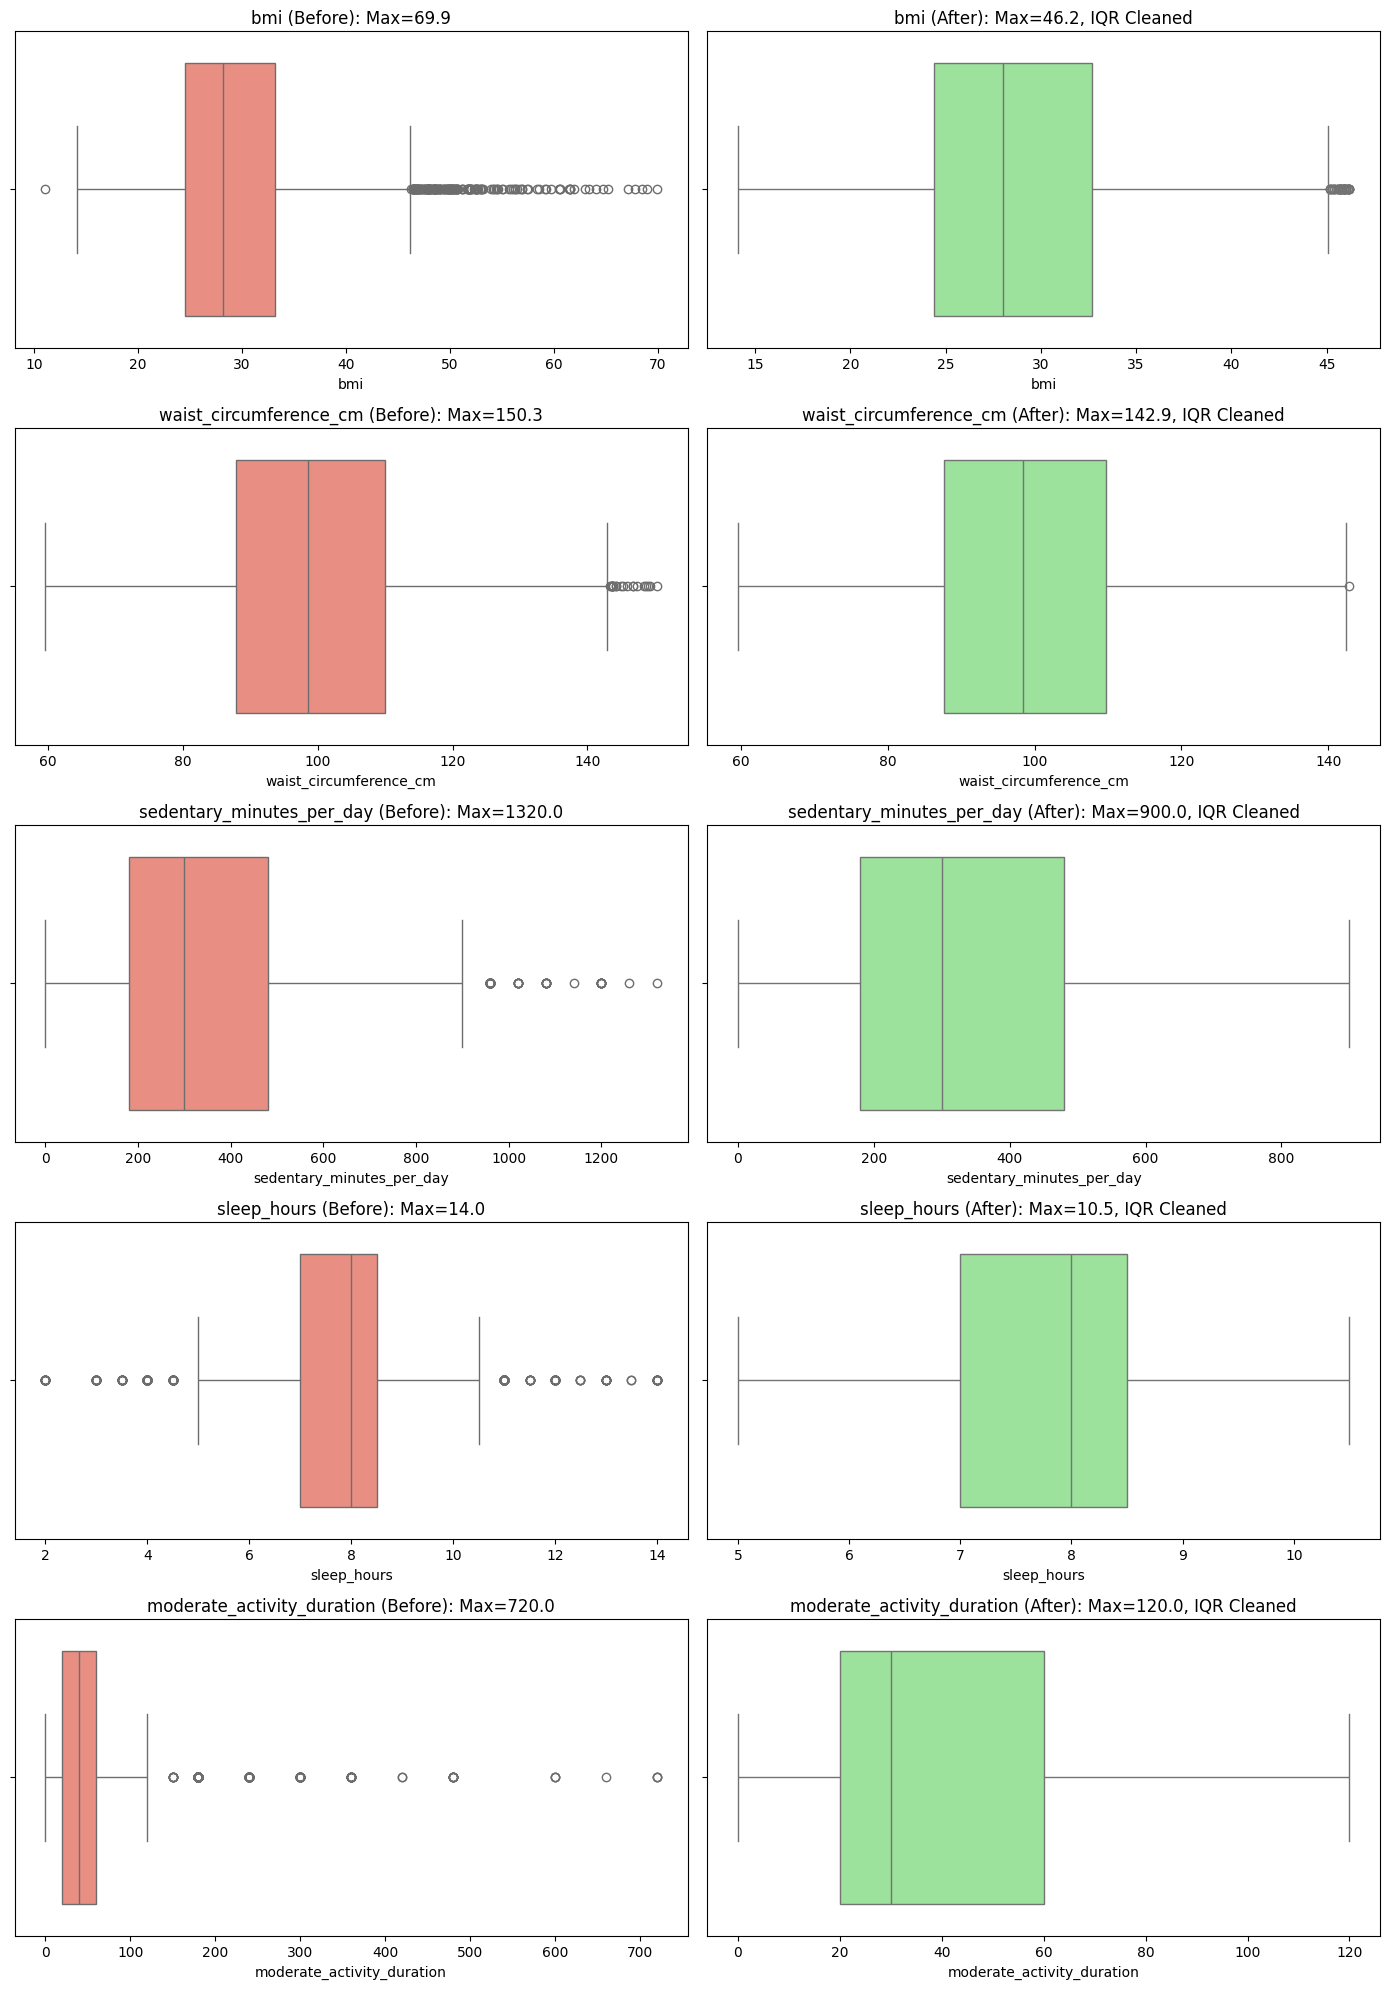

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

iqr_cols = [
    'bmi',
    'waist_circumference_cm',
    'sedentary_minutes_per_day',
    'sleep_hours',
    'moderate_activity_duration'
]

plt.figure(figsize=(14, 4 * len(iqr_cols)))
df_clean = df_final.copy()

for i, col in enumerate(iqr_cols):
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    original_data = df_clean[col].copy()

    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    ax1 = plt.subplot(len(iqr_cols), 2, 2*i + 1)
    sns.boxplot(x=original_data, ax=ax1, color='salmon')
    ax1.set_title(f'{col} (Before): Max={original_data.max():.1f}')

    ax2 = plt.subplot(len(iqr_cols), 2, 2*i + 2)
    sns.boxplot(x=df_clean[col], ax=ax2, color='lightgreen')
    ax2.set_title(f'{col} (After): Max={df_clean[col].max():.1f}, IQR Cleaned')

plt.tight_layout()
plt.show()

df_final = df_clean

limit =28   # 28/week = 4 /day a very high frequency, No higher freq is allowed
for col in ['moderate_activity_w','vigorous_activity_w']:
  df_final[col] = df_final[col].clip(upper=limit)

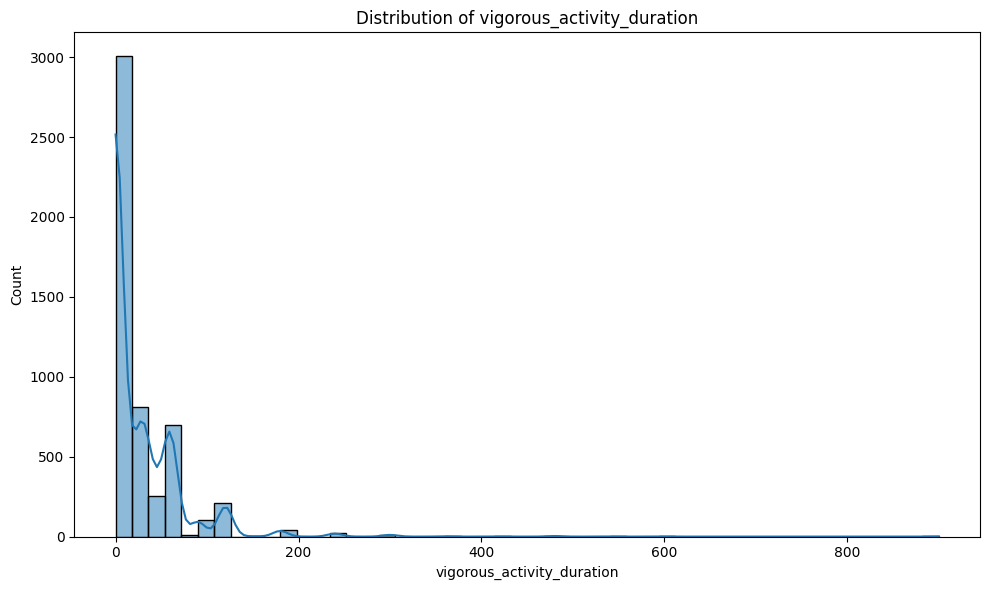

In [23]:
# Display the distribution pattern of column: vigorous_activity_duration
# To explore the reasonable upper limit
plt.figure(figsize=(10, 6))
sns.histplot(df_final['vigorous_activity_duration'], bins=50, kde=True)
plt.title('Distribution of vigorous_activity_duration')
plt.tight_layout()
plt.show()

It is clear that data over 250 can be considered as outliers. But in case that there are some "superman" doing a extremely large amount of exercise, capping those beyong 250 to 250.

In [24]:
limit = 250
df_final['vigorous_activity_duration'] = df_final['vigorous_activity_duration'].clip(upper=limit)

## 1.2 Pre-normalization

For the machine learning, the data should be normalized to optimize the efficiency of training and maximize the precision of prediction/prescription.

But normalizing some of the data here may do inconvenience on EDA, impair the intuitiveness carried with the number.

Therefore, here we only normalize one property: `gender` from catagory {1,2} (1 for male, 2 for female) to a one-hot encoding pattern {0,1} (0 for male, 1 for female).

In [25]:
df_final['gender']=df_final['gender'].map({1:0,2:1})

In [26]:
output_path = base_path + "cleaned_diabetes.csv"
df_final.to_csv(output_path, index=False)

# 2 EDA

## 2.1 Univariate

## 2.2 Bivariate Analysis

### 2.2.2 Spearman Correlation

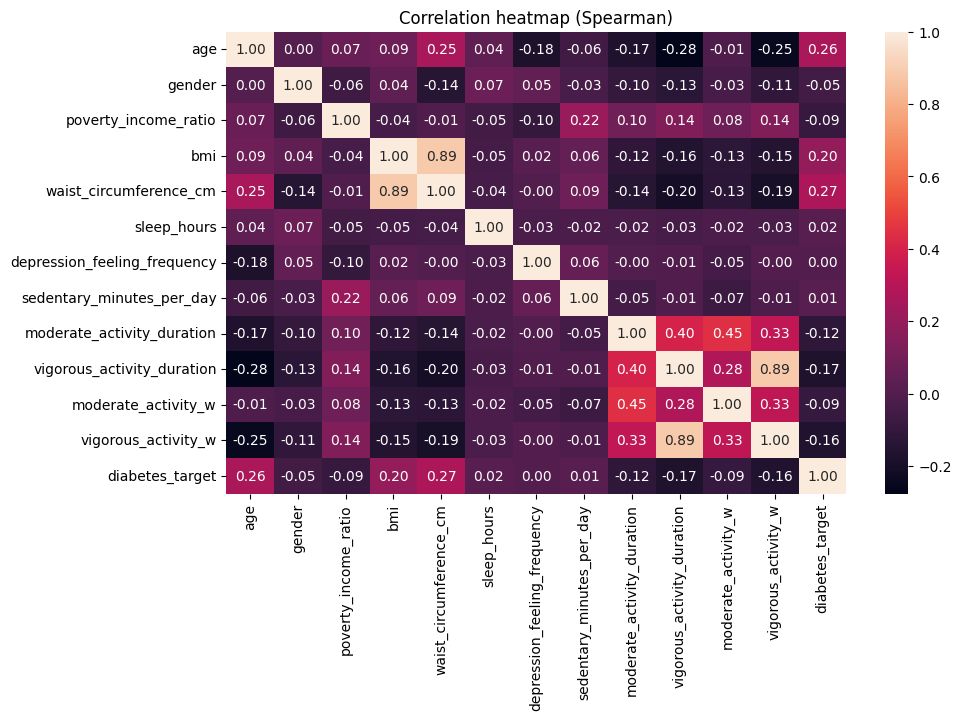

,age,gender,poverty_income_ratio,bmi,waist_circumference_cm,sleep_hours,depression_feeling_frequency,sedentary_minutes_per_day,moderate_activity_duration,vigorous_activity_duration,moderate_activity_w,vigorous_activity_w,diabetes_target
age,1.000000,0.003191,0.069633,0.086403,0.252328,0.040120,-0.180124,-0.055841,-0.166595,-0.276089,-0.014048,-0.246776,0.257450
gender,0.003191,1.000000,-0.063296,0.040831,-0.142580,0.073314,0.046863,-0.028645,-0.100071,-0.131879,-0.034548,-0.109017,-0.048028
poverty_income_ratio,0.069633,-0.063296,1.000000,-0.037616,-0.011435,-0.046841,-0.100678,0.216245,0.097386,0.140099,0.082922,0.137869,-0.087445
bmi,0.086403,0.040831,-0.037616,1.000000,0.889313,-0.045732,0.020477,0.057061,-0.115996,-0.159855,-0.126105,-0.154761,0.201448
waist_circumference_cm,0.252328,-0.142580,-0.011435,0.889313,1.000000,-0.040209,-0.004076,0.087062,-0.143679,-0.202948,-0.127682,-0.192645,0.271079
sleep_hours,0.040120,0.073314,-0.046841,-0.045732,-0.040209,1.000000,-0.026840,-0.017646,-0.022060,-0.033652,-0.017637,-0.025132,0.015760
depression_feeling_frequency,-0.180124,0.046863,-0.100678,0.020477,-0.004076,-0.026840,1.000000,0.059391,-0.002527,-0.009419,-0.045530,-0.000637,0.000327
sedentary_minutes_per_day,-0.055841,-0.028645,0.216245,0.057061,0.087062,-0.017646,0.059391,1.000000,-0.046787,-0.007524,-0.068605,-0.013408,0.013710
moderate_activity_duration,-0.166595,-0.100071,0.097386,-0.115996,-0.143679,-0.022060,-0.002527,-0.046787,1.000000,0.401390,0.445360,0.331619,-0.118364
vigorous_activity_duration,-0.276089,-0.131879,0.140099,-0.159855,-0.202948,-0.033652,-0.009419,-0.007524,0.401390,1.000000,0.281949,0.886608,-0.172806


In [27]:
# Correlation matrix (Spearman)
corr = df_final.corr(method = 'spearman')

# Creates a figure and draws a heatmap of the correlation matrix.
# annot=True prints the correlation values inside each cell.
# fmt=".2f" shows values with 2 decimal places.
# The heatmap makes it easy to spot strong relationships quickly.
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation heatmap (Spearman)")
plt.show()

# Displays the correlation matrix as a table as well (useful if you want exact values or to copy them).
corr

From the heatmap, we can preliminarily conclude that:
1. Age, bmi, activity level, and waist circum are the most significant factors.
2. Gender, sleep duration, depression level, sedentary level have little to do with diabetes.
3. BMI and waist circum are highly linear related, which implicated that they contains similar information. Therefore, we have to choose exactly one of them in machine learning model training, or it may lead significant instability on the model.
4. Variables about activity level are remarkably related to each other to. Thus we tend to apply the multiplication of each sort of frequency and duration, namely the totall excercise time per week, as a single variable. However, the correlation of frequency and duration of moderate activity is quite interesting, implicating that for low & middle-level exercise, the duration of each excercise help resist diabetes more than the frequency.

## 2.3 Multivariate Analysis

# 3 Feature Selection

## 3.1 Ask questions
* Given a certain person's non-invasive data, can we deecide the possibility that he/she has diabetes 5 years later?
* If we succeed in prediction, what we provide a high-diabetes-risk some suggestion on lowering the risk, with a certian quatity of

## 3.2 Select varibles

According to the result of EDA, we preserve all the columns except `sleep_hours`, `depression_feeling_frequency` and `sedentary_minutes_per_day` for they are little relevant to our target variable.

Furthermore, we should also drop `bmi` because it is highly related to waist circum, placing potential unstability under the model.
## 3.3 Reduction
Replace frequency and duration by their multiplication to reduce the unstability.

In [28]:
# Drop columns unselected
df_ml = df_final.drop(columns = ['sleep_hours','depression_feeling_frequency','sedentary_minutes_per_day','bmi'])

In [29]:
df_ml['moderate_activity_m_w'] = df_ml['moderate_activity_duration'] * df_ml['moderate_activity_w']
df_ml['vigorous_activity_m_w'] = df_ml['vigorous_activity_duration'] * df_ml['vigorous_activity_w']

df_ml = df_ml.drop(columns = ['moderate_activity_duration','moderate_activity_w','vigorous_activity_duration','vigorous_activity_w'])

It is not clear for how to distinguish "moderate" and "vigorous". And their correlations on diabetes are similar. Merge the two kinds of activity together.

In [30]:
df_ml["activity_level"] = df_ml["moderate_activity_m_w"] + df_ml["vigorous_activity_m_w"]

df_ml = df_ml.drop(columns = ['moderate_activity_m_w','vigorous_activity_m_w'])

Save the data features for future usage.

In [31]:
file_path_ml_feature = base_path + 'ml_feature.csv'
df_ml.describe().to_csv(file_path_ml_feature, index=False)

# 4 Model Training

In [32]:
df_ml.describe()

,age,gender,poverty_income_ratio,waist_circumference_cm,diabetes_target,activity_level
count,5178.000000,5178.000000,5178.000000,5178.000000,5178.000000,5178.000000
mean,52.296640,0.554461,2.933490,98.869003,0.158169,322.299667
std,18.150841,0.497073,1.553687,15.391579,0.364935,459.260624
min,18.000000,0.000000,0.000000,59.600000,0.000000,0.000000
25%,37.000000,0.000000,1.710000,87.500000,0.000000,60.000000
50%,56.000000,1.000000,2.500000,98.300000,0.000000,190.350000
75%,67.000000,1.000000,4.795000,109.500000,0.000000,420.000000
max,80.000000,1.000000,5.000000,142.900000,1.000000,6720.000000


## 4.1 Model Selection

## 4.2 Stratification

In [33]:
from sklearn.model_selection import train_test_split

X = df_ml.drop(columns=['diabetes_target'])
y = df_ml['diabetes_target']

# Split test set
# stratify=y make sure all the group has a percentage 15% of diabetics;
# Or it may probably generate a group with little diabetic proportion
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42, # Random seed = 42
    stratify=y
)

# Split validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765, # 0.1765 * 0.85 = 0.15
    random_state=42,
    stratify=y_temp
)

## Train : Validate : Test = 70 : 15 : 15

## 4.3 Normalization

We apply z-score to the process of standardization.

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Get scaled set
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation set with std and mean got from train set
X_val_scaled = scaler.transform(X_val)

# Do the same to test set
X_test_scaled = scaler.transform(X_test)

## 4.4 Baseline Comparison
* Logistic Regression
* Decision Tree
* Random Forest

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Initialize models

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = []

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Recall": rec,
        "F1-Score": f1
    })

results_df = pd.DataFrame(results)

print('=======Baseline Comparison======')
print(results_df.round(4))

=======Baseline Comparison======
                 Model  Accuracy  Recall  F1-Score
0  Logistic Regression    0.8443  0.1057    0.1769
1        Decision Tree    0.7568  0.2764    0.2646
2        Random Forest    0.8314  0.0894    0.1438


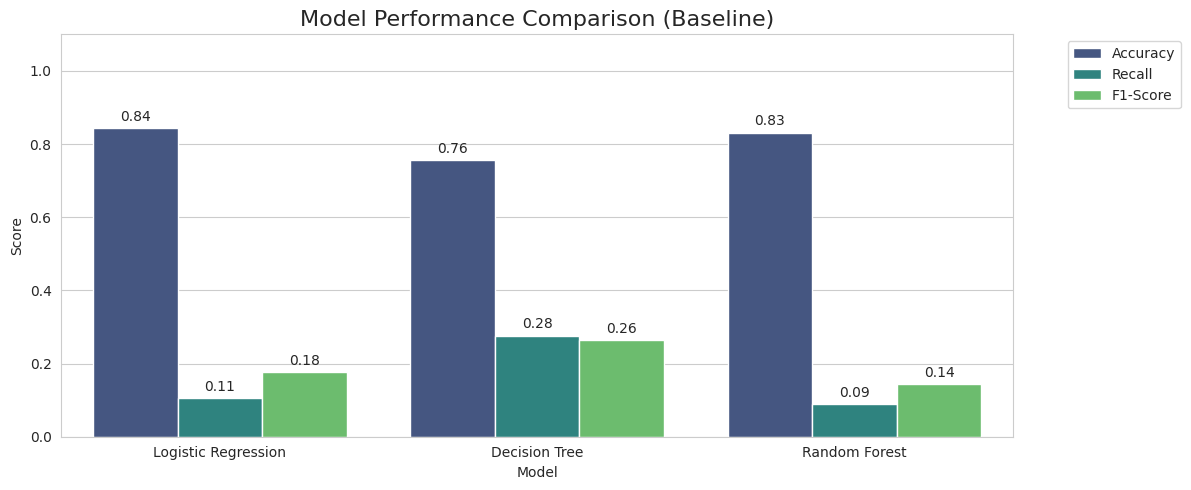

In [36]:
plt.figure(figsize=(12,5))
sns.set_style("whitegrid")

chart = sns.barplot(data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"), x="Model", y="Score", hue="Metric", palette="viridis")

for container in chart.containers:
    chart.bar_label(container, fmt='%.2f', padding=3)

plt.title("Model Performance Comparison (Baseline)", fontsize=16)
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # legend

plt.tight_layout()
plt.show()

We notice that all the models have high accurancy but low recall and low F1-score. To explain this, we can turn back to our dataset.

In [37]:
df_final['diabetes_target'].describe()

,diabetes_target
count,5178.000000
mean,0.158169
std,0.364935
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


`Diabetes_target` has binary values: 0 and 1, the mean = 0.158 shows that we only have 15.8% diabetics but 84.2% non-diabetics.  
Therefore, to achieve a high accuracy, the model tend to predict all the subjects as healthy. By doing that, we can achieve an accuracy of 84.2% while it is meaningless. In practice, we can easily re-examine a patient to eliminate a fake postive, but it will be hard to deal with if there is a high rate of fake negative.  

To value the `Recall` = $\frac{TP}{TP+FN}$, we will order all the 3 models as class_weight = 'balanced', and train the models again.

In [38]:
# Initialize models

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced',random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced',random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced',random_state=42)
}

results = []

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Recall": rec,
        "F1-Score": f1
    })

results_df = pd.DataFrame(results)

print('=======Baseline Comparison======')
print(results_df.round(4))

=======Baseline Comparison======
                 Model  Accuracy  Recall  F1-Score
0  Logistic Regression    0.7066  0.7236    0.4384
1        Decision Tree    0.7671  0.2358    0.2427
2        Random Forest    0.8353  0.0732    0.1233


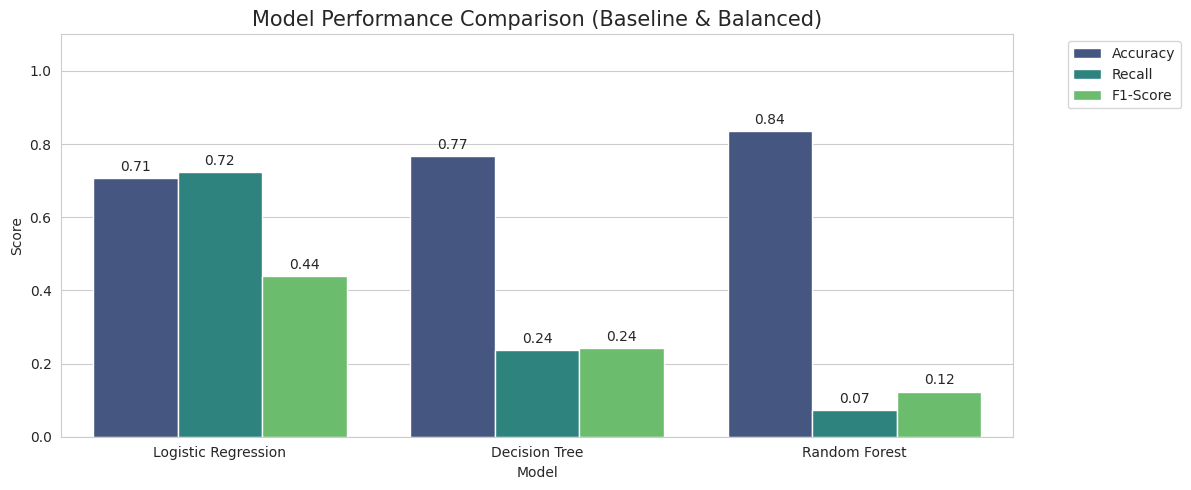

In [39]:
plt.figure(figsize=(12,5))
sns.set_style("whitegrid")

chart = sns.barplot(data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"), x="Model", y="Score", hue="Metric", palette="viridis")

for container in chart.containers:
    chart.bar_label(container, fmt='%.2f', padding=3)

plt.title("Model Performance Comparison (Baseline & Balanced)", fontsize=15)
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # legend

plt.tight_layout()
plt.show()

It is clear that Logistic Regression beat the other two models on diabetic prediction. By making the regression penalty weighted, logistic regression become significantly valuing patients. With a decrement in accuracy from 0.84 to 0.71, the recall surges from 0.11 to 0.72, while the other two "rebellious" models' recall become even lower.  

It is worthy reflection that a logically simpler model perform much better than its more complex peers.

## 4.5 Fine-Tuning

As we have found out that the best model is Logistic Regression, here we further tune-fine the model to explore if we can achieve even better performance.

The parameter in Logistic Regression model is `c`, which represents the reciprocal of the coefficient of regularization. With smaller `c`, the sum of all the square/absolution value of coefficients will be limited to a small amount, resulting in an underfitting; with larger `c`, the condition is opposite -- overfitting.

Here we change `c` to see where the Logistic Regression model performs best.

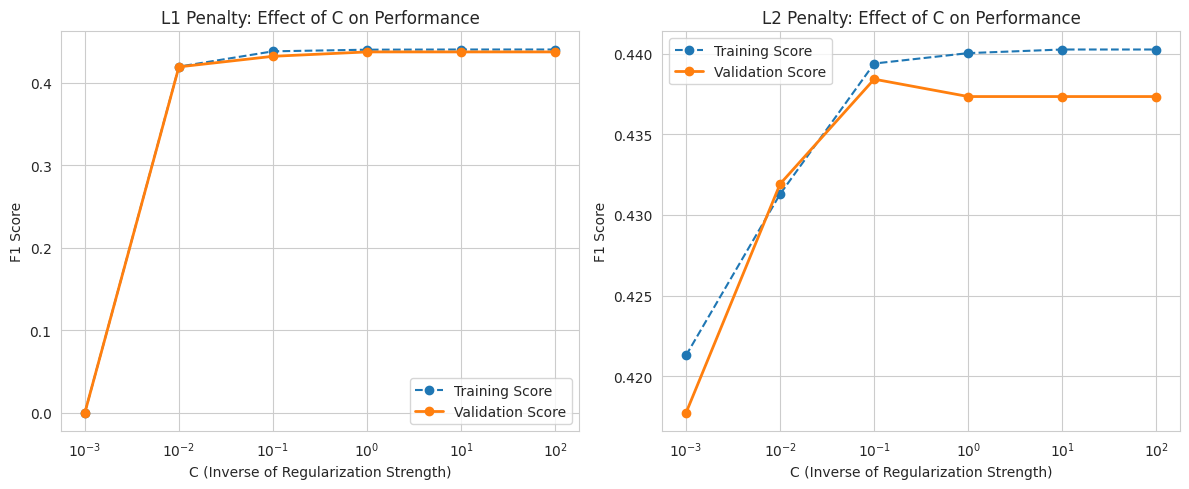

In [40]:
c_values = [0.001, 0.01, 0.1, 1, 10, 100]
penalty_patterns = ['l1','l2']

results = []

for p in penalty_patterns:
    for c in c_values:
        model = LogisticRegression(penalty=p, C=c, class_weight='balanced', solver = 'liblinear', random_state=42)
        model.fit(X_train_scaled, y_train)

        # Predict on training model to see if there is an overfitting
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)

        # save F1 score
        train_score = f1_score(y_train, y_train_pred)
        val_score = f1_score(y_val, y_val_pred)

        # save data together
        results.append({
            'Penalty': p,
            'C': c,
            'Train_Score': train_score,
            'Val_Score': val_score
        })

df_results = pd.DataFrame(results)

plt.figure(figsize=(12, 5))

# subplot for model L1 (absolute)
plt.subplot(1, 2, 1)
data_l1 = df_results[df_results['Penalty'] == 'l1']
plt.plot(data_l1['C'], data_l1['Train_Score'], marker='o', label='Training Score', linestyle='--')
plt.plot(data_l1['C'], data_l1['Val_Score'], marker='o', label='Validation Score', linewidth=2)
plt.xscale('log')
plt.title('L1 Penalty: Effect of C on Performance')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# subplot for model L2 (square)
plt.subplot(1, 2, 2)
data_l2 = df_results[df_results['Penalty'] == 'l2']
plt.plot(data_l2['C'], data_l2['Train_Score'], marker='o', label='Training Score', linestyle='--')
plt.plot(data_l2['C'], data_l2['Val_Score'], marker='o', label='Validation Score', linewidth=2)
plt.xscale('log')
plt.title('L2 Penalty: Effect of C on Performance')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The scale of vertical axis differ a lot among two penalty patterns. We focusing on the performance of two patterns around $c=0.1$ to see the behavior of these two curves more clearly.

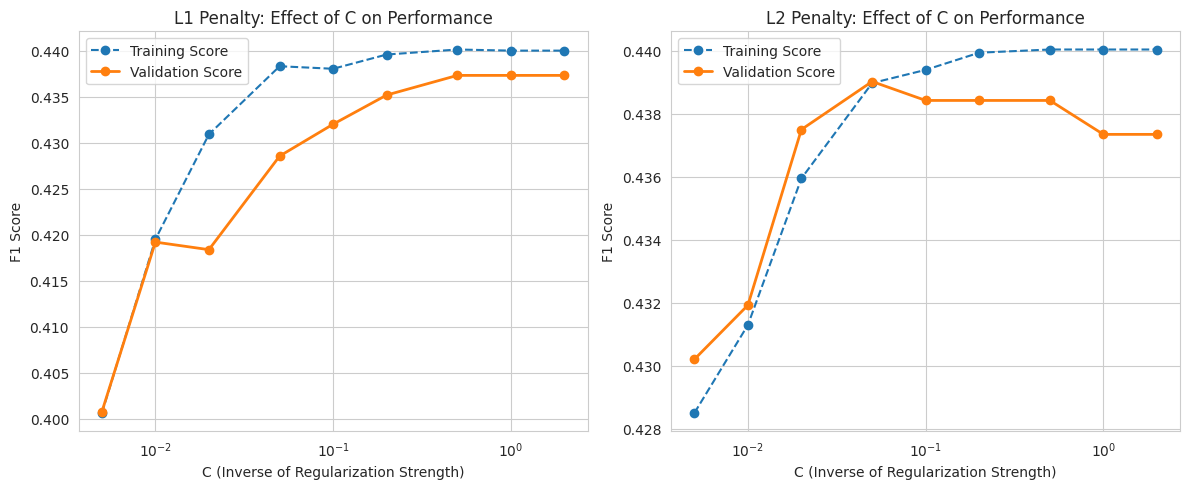

In [41]:
c_values = [0.005 ,0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
penalty_patterns = ['l1','l2']

results = []

for p in penalty_patterns:
    for c in c_values:
        model = LogisticRegression(penalty=p, C=c, class_weight='balanced', solver = 'liblinear', random_state=42)
        model.fit(X_train_scaled, y_train)

        # Predict on training model to see if there is an overfitting
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)

        # save F1 score
        train_score = f1_score(y_train, y_train_pred)
        val_score = f1_score(y_val, y_val_pred)

        # save data together
        results.append({
            'Penalty': p,
            'C': c,
            'Train_Score': train_score,
            'Val_Score': val_score
        })

df_results = pd.DataFrame(results)

plt.figure(figsize=(12, 5))

# subplot for model L1 (absolute)
plt.subplot(1, 2, 1)
data_l1 = df_results[df_results['Penalty'] == 'l1']
plt.plot(data_l1['C'], data_l1['Train_Score'], marker='o', label='Training Score', linestyle='--')
plt.plot(data_l1['C'], data_l1['Val_Score'], marker='o', label='Validation Score', linewidth=2)
plt.xscale('log')
plt.title('L1 Penalty: Effect of C on Performance')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# subplot for model L2 (square)
plt.subplot(1, 2, 2)
data_l2 = df_results[df_results['Penalty'] == 'l2']
plt.plot(data_l2['C'], data_l2['Train_Score'], marker='o', label='Training Score', linestyle='--')
plt.plot(data_l2['C'], data_l2['Val_Score'], marker='o', label='Validation Score', linewidth=2)
plt.xscale('log')
plt.title('L2 Penalty: Effect of C on Performance')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Considering the smaller scale of axis y in the graph of L2, two patterns shows similar fluctuation. But L2's validation performance fit that of its training performance better. Therefore, we take `L2` as a better penalty pattern.

As for `c`, we choose `c=0.05` as the best which is the inflection point. It is where the curve goes gentle after a steep incline, which means it balances the overfitting and underfitting.

In [42]:
penalty_best = 'l2'
C_best = 0.05

In [43]:
feature_names = X_train.columns.tolist()

best_model = LogisticRegression(C = C_best, penalty= penalty_best, random_state=42, class_weight = 'balanced', solver='liblinear')
best_model.fit(X_train_scaled, y_train)

coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_model.coef_[0]
})

print(coefs)

                  Feature  Coefficient
0                     age     0.857793
1                  gender    -0.104695
2    poverty_income_ratio    -0.319180
3  waist_circumference_cm     0.750378
4          activity_level    -0.074648


# 5 Evaluation
This part we walk our model through the test set to assess its final performance and lead to our conclusion.

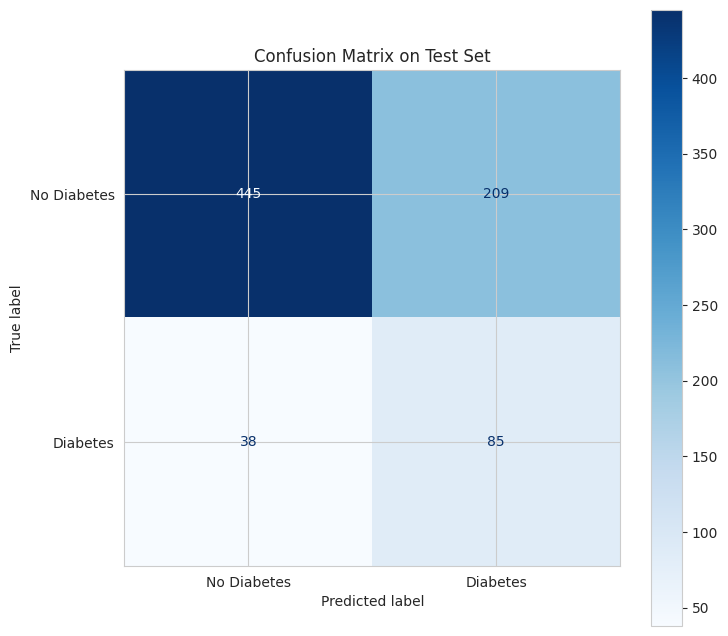

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = LogisticRegression(C = C_best, penalty= penalty_best, random_state=42, class_weight = 'balanced', solver='liblinear')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])


fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix on Test Set')
plt.show()

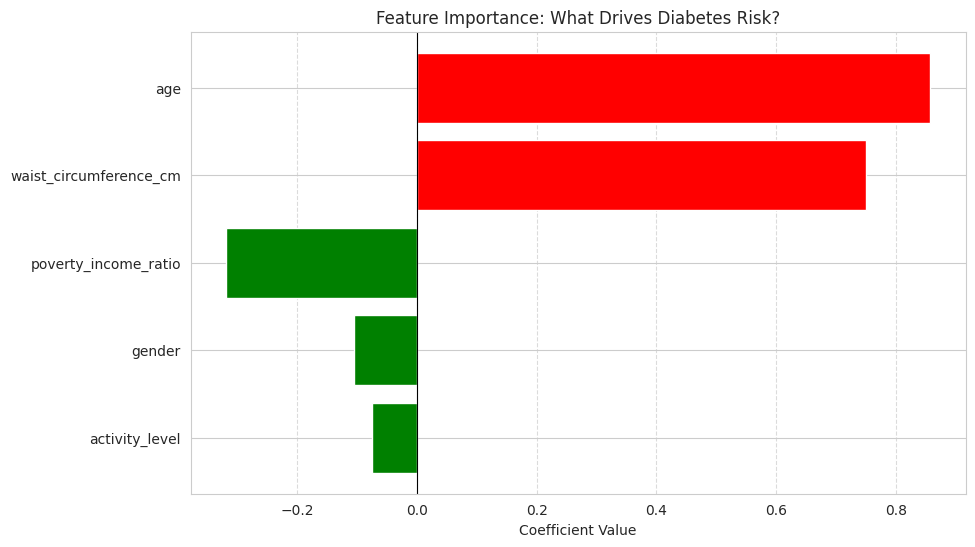

In [44]:
# Sort the coefficients with abs
coefs = coefs.reindex(coefs['Coefficient'].abs().sort_values(ascending=True).index)

# Red for Pathogenic  Green for Diease-resistant   Factors
colors = ['red' if c > 0 else 'green' for c in coefs['Coefficient']]

plt.figure(figsize=(10, 6))
plt.barh(coefs['Feature'], coefs['Coefficient'], color=colors)
plt.title('Feature Importance: What Drives Diabetes Risk?')
plt.xlabel('Coefficient Value')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()